In [1]:
import ioutils 
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, GenerationConfig
import torch
model = ESM3.from_pretrained("esm3_sm_open_v1", device="cpu")

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tensorboard

140159749567488

In [56]:
import numpy as np
a = np.array([1,2,3,4,5]) 
b = np.zeros(50000000)
id(a), id(b)

(140143573995600, 140143574001744)

In [11]:
import json 
import trainUtils
with open("/home/tyfei/evoModel/checkpoints/CrossGene/config.json") as f:
    configs = json.load(f)

In [12]:
pretrain_model = trainUtils.loadPretrainModel(configs)
model = trainUtils.buildModel(configs, pretrain_model, None)
ds = trainUtils.loadDataset(configs)

In [13]:
ckpt = torch.load("/home/tyfei/evoModel/checkpoints/CrossGene/last.ckpt")
ckpt

{'epoch': 6,
 'global_step': 66000,
 'pytorch-lightning_version': '2.3.3',
 'state_dict': OrderedDict([('encoder_blocks.0.mha.in_proj_weight',
               tensor([[ 2.9423e-09,  3.8021e-09, -1.2763e-15,  ..., -4.9468e-07,
                        -3.8817e-14,  2.5423e-17],
                       [-2.3318e-17,  6.9085e-18, -1.4310e-11,  ..., -5.7912e-17,
                        -2.9256e-09,  5.2831e-10],
                       [ 1.8825e-06,  1.4359e-11,  7.9189e-08,  ..., -7.8040e-14,
                         1.0228e-11, -1.0684e-15],
                       ...,
                       [ 7.8767e-10, -9.6251e-10,  2.6132e-11,  ...,  5.6801e-08,
                         7.2873e-11, -1.7570e-09],
                       [ 2.3838e-10,  6.0127e-10,  9.2258e-09,  ...,  1.9623e-08,
                        -7.5691e-10, -1.5764e-07],
                       [ 1.8984e-11, -2.7736e-06,  1.6988e-14,  ...,  8.7108e-14,
                         1.9360e-13, -3.5940e-12]], device='cuda:2')),
           

In [40]:
with open("/data/tyfei/datasets/covid/teststage2_lr_backbone_80000.pkl", "rb") as f:
    data = pickle.load(f)

In [43]:
q = [] 
for i in range(1000):
    t = [data[i]["S"], data[i]["E"], data[i]["NSP5"]]
    t = np.concatenate(t)
    q.append(t)
q

NameError: name 'np' is not defined

In [14]:
model.load_state_dict(ckpt["state_dict"], strict=False)
model = model.cuda(4)

In [18]:
model.only_embed = True

In [19]:
d = ds.val_dataloader()
q = []
labels = ["S"]*300+["NSP5"]*300+["E"]*300
with torch.no_grad():
    cnt = 0
    for i, j in enumerate(d):
        inputs = j[0]
        for i in inputs:
            inputs[i] = inputs[i].cuda(4)
        # labels.append(j[0]["prot"])
        # j[0]["seq_t"] = j[0]["seq_t"].cuda(4)
        res = model(inputs).cpu().squeeze().numpy()
        q.append(res)
        cnt += 1 
        if (cnt % 1000 == 0):
            break
    # break

In [20]:
from sklearn.decomposition import PCA
import numpy as np
q = np.stack(q, axis=0)
pca = PCA(n_components=20)
pca_seq = pca.fit_transform(q)
pca_seq.shape 
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

In [27]:
labels = ["Full"]*1000
X_embedded.shape

(1000, 2)

In [30]:
df

,x,y,labels
0,-164.672653,133.753830,Full
1,-91.680458,160.027634,Full
2,-90.781723,152.466171,Full
3,-146.861862,-70.675011,Full
4,-184.108566,96.977150,Full
...,...,...,...
995,12.168350,-2.541945,Full
996,-149.316833,2.793270,Full
997,-149.316833,2.793270,Full
998,-149.316833,2.793270,Full


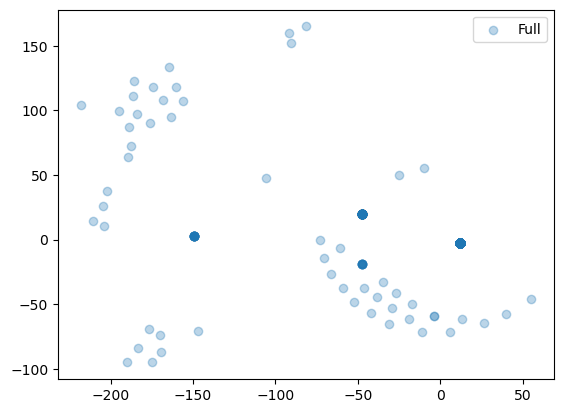

In [32]:
import pandas as pd
import matplotlib.pyplot as plt 
# labels = ["S"]*320+["NSP5"]*320+["E"]*320
df = pd.DataFrame({"x": X_embedded[:, 0], "y": X_embedded[:, 1], "labels": labels})
for i in ["Full"]:
    subdf = df[df["labels"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, alpha=0.3)
plt.legend()

In [27]:
ori = {}

In [28]:
import pickle 
with open("/data/tyfei/datasets/covid/S_aln.pkl", "rb") as f:
    a = pickle.load(f) 
ori["S"] = a[0]["seq_t"]
with open("/data/tyfei/datasets/covid/E_aln.pkl", "rb") as f:
    a = pickle.load(f) 
ori["E"] = a[0]["seq_t"]
with open("/data/tyfei/datasets/covid/NSP5_aln.pkl", "rb") as f:
    a = pickle.load(f) 
ori["NSP5"] = a[0]["seq_t"]

In [33]:
with open("/data/tyfei/datasets/covid/S_aln.pkl", "rb") as f:
    a = pickle.load(f) 
a

[{'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,  2])},
 {'prot': 'S', 'seq_t': array([ 0, 20, 18, ..., 19, 11,

In [37]:
a[512]["seq_t"].shape, a[0]["seq_t"].shape

((1273,), (1275,))

In [9]:
with open("/data/tyfei/datasets/covid/ori_seq.pkl", "wb") as f:
    pickle.dump(ori, f)

NameError: name 'pickle' is not defined

In [27]:
q = [] 
res = model(j[0])
res.shape

torch.Size([1, 256])

In [20]:
import pickle
import os
seqs = ioutils.readFasta("/data/tyfei/datasets/covid/s_dict_20211206_20241005_common_sequences.fasta", checkseq=None)
# seqs

In [21]:
import pandas as pd
df = pd.read_csv("/data/tyfei/datasets/covid/full.csv", header=0, index_col=0)
df.head()

/tmp/ipykernel_3430248/1518760760.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/data/tyfei/datasets/covid/full.csv", header=0, index_col=0)


,release_date,country,is_recommend
virus_id,,,
OEAV5283017,2021-12-20,Bangladesh,True
OEAV5283018,2021-12-20,Bangladesh,True
OEAV5283019,2021-12-20,Bangladesh,True
OEAV5283020,2021-12-20,Bangladesh,True
OEAV5283021,2021-12-20,Bangladesh,True


In [22]:
i = [seq[0] for seq in seqs]
i, len(i)

(['OEAV21228893',
  'OEAV6351580',
  'OEAV22692345',
  'OEAV6376775',
  'OEAV22398934',
  'OEAV6382661',
  'OEAV5451516',
  'OEAV21772705',
  'OEAV21256101',
  'OEAV21980934',
  'OEAV21847496',
  'OEAV21314853',
  'OEAV6524093',
  'OEAV20610921',
  'OEAV19686959',
  'OEAV22509909',
  'OEAV21537406',
  'OEAV22405215',
  'OEAV22677261',
  'OEAV21787370',
  'OEAV22309650',
  'OEAV21842416',
  'OEAV22009041',
  'OEAV21603618',
  'OEAV22410871',
  'OEAV6525799',
  'OEAV5294389',
  'OEAV22234117',
  'OEAV21264252',
  'OEAV21790304',
  'OEAV6376886',
  'OEAV21256591',
  'OEAV6516322',
  'OEAV21960181',
  'OEAV6377912',
  'OEAV22498754',
  'OEAV21263076',
  'OEAV22431174',
  'OEAV21787826',
  'OEAV22526153',
  'OEAV22333387',
  'OEAV22007778',
  'OEAV22570793',
  'OEAV21516938',
  'OEAV5290028',
  'OEAV21517154',
  'OEAV21259670',
  'OEAV22423532',
  'OEAV22454389',
  'OEAV21761305',
  'OEAV19618929',
  'OEAV21978571',
  'OEAV22003457',
  'OEAV6113815',
  'OEAV6382601',
  'OEAV21055987',
  'OE

In [25]:
df.reindex(i).dropna()
df["new country"] = df["country"].apply(lambda x: "United States" if x == "USA" else x)


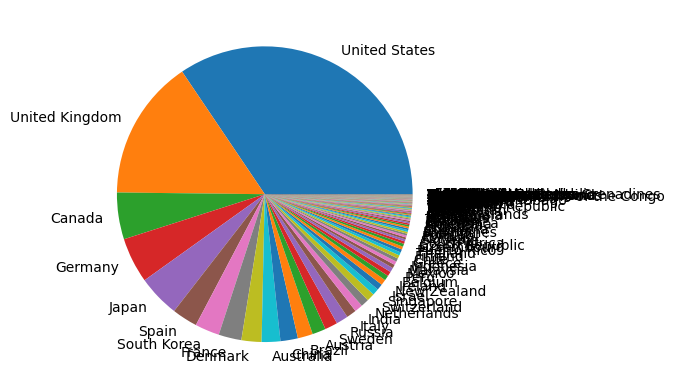

In [26]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('pdf', fonttype=42)
plt.pie(df["new country"].value_counts(), labels=df["new country"].value_counts().index)
plt.savefig("country.pdf")

In [ ]:
df = pd.read_csv("/data/tyfei/datasets/covid/allprot0505/", header=0, index_col=0)

In [36]:
df = pd.read_csv("/data/tyfei/datasets/Mprot/fulldata.tsv", header=0, index_col=0, sep="\t")
df.head()

/tmp/ipykernel_3430248/269815410.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/data/tyfei/datasets/Mprot/fulldata.tsv", header=0, index_col=0, sep="\t")


,Accession ID,Collection date,Location,Host,Passage,Specimen,Additional host information,Sampling strategy,Sequencing technology,Assembly method,Comment,Comment type,Lineage,Clade,AA Substitutions,seq
Virus name,,,,,,,,,,,,,,,,
hCoV-19/Netherlands/NA_128/2020,EPI_ISL_422672,2020-03-17,Europe / Netherlands,Human,Original,NaN,NaN,NaN,Nanopore,NaN,Gap of 3 nucleotides when compared to the refe...,info,B.11,L,"(NSP13_R392C,NSP2_D268del)",SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
hCoV-19/France/ARA-11950/2020,EPI_ISL_419172,2020-03-21,Europe / France / Auvergne-Rhone-Alpes / Lyon,Human,Original,Nasopharyngeal swab,NaN,NaN,Illumina NextSeq,"bwa, samtools, custom",NaN,NaN,B.1,GH,"(NS3_Q57H,NSP12_P323L,Spike_D614G)",SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
hCoV-19/Iceland/448/2020,EPI_ISL_424472,2020-03-20,Europe / Iceland / Reykjavik,Human,Original,NaN,NaN,NaN,Illumina MiSeq,Mpileup,NaN,NaN,B.3,L,"(NSP2_G212D,NSP3_A58T,NSP3_Q474R)",SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
hCoV-19/USA/NY-NYUMC57/2020,EPI_ISL_420572,2020-03-17,North America / USA / New York / Nassau County,Human,Original,NaN,NaN,NaN,"Targeted capture, Illumina Novaseq","bwa v0.7.17, bases <30x masked",NaN,NaN,B.1.319,GH,"(NS3_Q57H,NSP5_A266V,NSP2_T85I,NSP12_P323L,Spi...",SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
hCoV-19/Iceland/38/2020,EPI_ISL_417672,2020-03-16,Europe / Iceland / Reykjavik,Human,Original,NaN,NaN,NaN,Illumina MiSeq,Mpileup,NaN,NaN,B,O,(NS3_G251V),SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...


In [37]:
import ioutils 
get_time = ioutils.getDate()
df["time"] = df["Collection date"].apply(get_time) 
df["q"] = pd.cut(df["time"], 100)

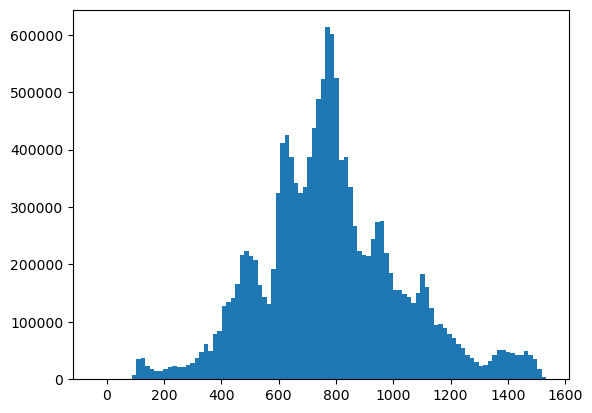

In [39]:
plt.hist(df["time"], bins=100)
plt.savefig("time.pdf")

In [4]:
import os
import pickle
ori_seqs = {}
get_time = ioutils.getDate()
for f in os.listdir("/data/tyfei/datasets/covid/"):
    if f.endswith("_dict_20211206_20241005_common_sequences.fasta"):
        print(f)
        seqs = ioutils.readFasta("/data/tyfei/datasets/covid/"+f, checkseq=None)
        name = f.split("_")[0]
        allres = [] 
        cnt = 0
        tt = -1
        for seq in seqs:
            if (cnt+1) % 100000 == 0:
                print(cnt)
            # if cnt > 6000000:
            #     break
            cnt += 1
            if tt == -1:
                tt = len(seq[1])
                print(tt)
                
            # print(seq)
            # info = seq[0].split("|")
            # if not info[3].startswith("EPI"):
            #     continue
            # if info[0] not in ["E", "NSP5", "Spike"]:
            #       continue
            t = seq[1]
            if len(seq[1]) < tt:
                t = t+"-"*(tt-len(t))
            protein = ESMProtein(sequence=t)
            res = model.encode(protein)
            data = {}
            data["prot"] = name
            # data["date"] = get_time(info[2])
            # data["country"] = info[-1]
            data["id"] = seq[0]
            data["seq_t"] = res.sequence.cpu().numpy()
            if name not in ori_seqs:
                ori_seqs[name] = data["seq_t"]
            allres.append(data)
        with open("/data/tyfei/datasets/covid/%s_paired_sequences.pkl"%name, "wb") as f:
            pickle.dump(allres, f)
    # print(data)
    # break

nsp12_dict_20211206_20241005_common_sequences.fasta
923
99999
199999
299999
399999
n_dict_20211206_20241005_common_sequences.fasta
416
99999
199999
299999
399999
nsp13_dict_20211206_20241005_common_sequences.fasta
601
99999
199999
299999
399999
s_dict_20211206_20241005_common_sequences.fasta
1273
99999
199999
299999
399999
nsp5_dict_20211206_20241005_common_sequences.fasta
306
99999
199999
299999
399999
nsp3_dict_20211206_20241005_common_sequences.fasta
1500
99999
199999
299999
399999
e_dict_20211206_20241005_common_sequences.fasta
75
99999
199999
299999
399999
nsp6_dict_20211206_20241005_common_sequences.fasta
287
99999
199999
299999
399999
nsp4_dict_20211206_20241005_common_sequences.fasta
500
99999
199999
299999
399999
nsp16_dict_20211206_20241005_common_sequences.fasta
298
99999
199999
299999
399999
nsp7_dict_20211206_20241005_common_sequences.fasta
83
99999
199999
299999
399999
nsp11_dict_20211206_20241005_common_sequences.fasta
9
99999
199999
299999
399999
m_dict_20211206_2024100

In [10]:
with open("/data/tyfei/datasets/covid/NSP5_aln.pkl", "wb") as f:
    pickle.dump(allres, f)

In [15]:
import pickle 
ori = {}
for i in ("/data/tyfei/datasets/covid/E_aln.pkl", "/data/tyfei/datasets/covid/NSP5_aln.pkl", "/data/tyfei/datasets/covid/S_aln.pkl"):
    with open(i, "rb") as f:
        a = pickle.load(f)
        print(len(a), a[0]["prot"])
        ori[a[0]["prot"]] = a[0]["seq_t"]

811124 E
811124 NSP5
811124 S


In [5]:
with open("/data/tyfei/datasets/covid/ori_seq.pkl", "wb") as f:
    pickle.dump(ori_seqs, f)

In [11]:
t1 = [] 
t2 = [] 
t3 = [] 
for i in os.listdir("/data/tyfei/datasets/covid/"):
    if i.endswith("_paired_sequences.pkl"):
        t1.append(500)
        t2.append(50)
        t3.append("/data/tyfei/datasets/covid/"+i)

In [14]:
t2

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [ ]:

len(allres)

833661

In [51]:
len(res)

78